In [486]:
import numpy as np
from pprint import pprint
import sys, os
import matplotlib.pyplot as plt

sys.path.append('utils')
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from fish_graph_utils import *
from neuron import h

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


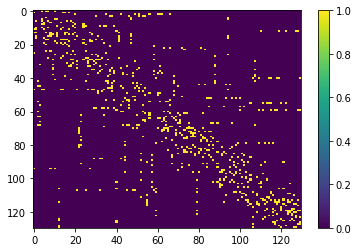

In [342]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram('params/circuitparams.yaml', place_information)
diagram.generate_internal_connectivity()

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0], aspect='auto')
plt.colorbar()
plt.show()


place_cells = diagram.place_information[0]['place']
cue_cells = diagram.place_information[0]['not place']


In [671]:
circuit = Circuit('params/circuitparams_ripple.yaml', diagram.pop2id, None)
circuit.build_cells()
circuit.build_internal_netcons(diagram.internal_adj_matrices)


In [672]:

#model_filepath =  'models/48-trained-cue-on-inhplas-off-lecplas-off-15iter.npz'
model_filepath =  'models/48-trained-cue-on-inhplas-ie-lecplas-off-20iter.npz'
f = np.load(model_filepath, allow_pickle=True)
fkeys = f.keys()
for fk in fkeys:
    try: fk = int(fk)
    except: 
        print('fail:',fk)
        continue

    population_info = circuit.neurons[fk]
    weights = f[str(fk)]
    counter = 0
    for cell_gid in population_info.keys():
        cell_info = population_info[cell_gid]
        for (presynaptic_gid, nc, _) in cell_info.internal_netcons:
            for netcon in nc:
                base_weight  = weights[counter]
                added_weight = weights[counter + 1]
                total_weight = base_weight + added_weight
                if fk == 0 and presynaptic_gid >= 130: 
                    total_weight *= 0.70
                    #total_weight *= 0.50
                netcon.weight[0] = total_weight
                counter += 2

    print(len(weights), counter)
    

fail: frs
fail: spikes
fail: valid_gids
47800 5720
14760 2160


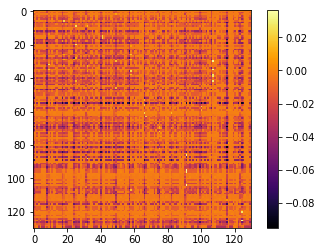

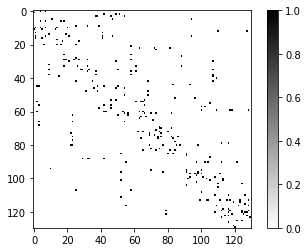

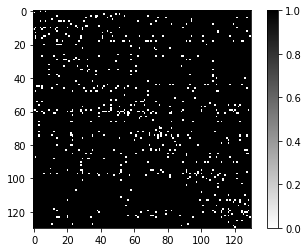

In [673]:
def get_adjacency_weights(circuit):
    ncells = 0
    population_ids = []
    for c in circuit.neurons.keys():
        if type(c) == int:
            pop = circuit.neurons[c]
            ncells += len(pop)
            population_ids.append(c)
    adj_matrix = np.zeros((ncells, ncells), dtype='float32') # pre x post
    
    cid_absolute = 0
    for pop_id in population_ids:
        for cell_id in circuit.neurons[pop_id]:
            cell_internal_netcons = circuit.neurons[pop_id][cell_id].internal_netcons
            for (presynaptic_gid, ncs, _) in cell_internal_netcons:
                for nc in ncs:
                    weight = nc.weight[0]
                    if len(nc.weight) == 2:
                        weight += nc.weight[1]
                    adj_matrix[presynaptic_gid, cid_absolute] += weight
            cid_absolute += 1
    return adj_matrix

def reduced_adj_matrix(adj_matrix, exc_ids, inh_ids, norm=False):
    nexc, ninh = len(exc_ids), len(inh_ids)
    reduced_matrix = np.zeros((nexc, nexc), dtype='float32')
    
    for src_exc_id in exc_ids:
        exc_to_inh = adj_matrix[src_exc_id,nexc:]
        for inh_id in inh_ids:
            if exc_to_inh[inh_id-nexc] > 0.0:
                inh_to_dst_exc = adj_matrix[inh_id,:nexc]
                for (dst_exc_id, w) in enumerate(inh_to_dst_exc):
                    if w > 0.0:
                        reduced_matrix[src_exc_id, dst_exc_id] -= ( 0.5*(w+exc_to_inh[inh_id-nexc]) )
                        
    for exc_src in exc_ids:
        for exc_dst in exc_ids:
            if exc_src == exc_dst: continue
            reduced_matrix[exc_src, exc_dst] += adj_matrix[exc_src, exc_dst]
    if norm:
        reduced_matrix /= abs(reduced_matrix.min())
    return reduced_matrix
        
full_adj_matrix = get_adjacency_weights(circuit)
reduced_adj = reduced_adj_matrix(full_adj_matrix, np.arange(0,130), np.arange(130,145), norm=False)



plt.figure()
plt.imshow(reduced_adj, cmap='inferno')
plt.colorbar()
plt.show()


from copy import deepcopy
pos_th_reduced_adj = deepcopy(reduced_adj)
pos_th_reduced_adj[pos_th_reduced_adj>0] = 1
pos_th_reduced_adj[pos_th_reduced_adj<=0] = 0

neg_th_reduced_adj = deepcopy(reduced_adj)
neg_th_reduced_adj[neg_th_reduced_adj>=0] = 0
neg_th_reduced_adj[neg_th_reduced_adj<0] = 1
#neg_th_reduced_adj *= -1

plt.figure()
plt.imshow(pos_th_reduced_adj, cmap='gray_r')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(neg_th_reduced_adj, cmap='gray_r')
plt.colorbar()
plt.show()



In [356]:
def generate_igraph(A, directed=False):
    import igraph as ig
    if not directed:
        A = np.triu(A)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(A.shape[0])
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except BaseException:
        print('base exception excepted..')
        pass
    return g, weights

def get_modularity(graph, partitions, weights=None):
    return graph.modularity(partitions, weights=weights)
    import leidenalg
    part = leidenalg.find_partition(graph, leidenalg.RBConfigurationVertexPartition, resolution_parameter=1.0)
    part = part.membership  
    
    modularity = graph.modularity(part, weights=weights)
    return modularity 

pos_graph, pos_weights = generate_igraph(pos_th_reduced_adj, directed=True)
neg_graph, neg_weights = generate_igraph(neg_th_reduced_adj, directed=True)

partition = np.ones(len(place_cells) + len(cue_cells) + 15)
partition[place_cells] = 0
partition[130:] = 2

pos_modularity = get_modularity(pos_graph, partition, weights=pos_weights)
#neg_modularity = get_modularity(neg_graph, partition, weights=neg_weights)

print('pos', pos_modularity)
#print('neg', neg_modularity)
#print(pos_modularity - neg_modularity)

s = 0
for c in cue_cells:
    for c2 in cue_cells:
        if c == c2: continue
        if pos_th_reduced_adj[c,c2]: s +=1 
print(s)


pos -0.02334533011661859
20


In [674]:
#def run_local_higher_order_analysis(nid, input_filepath, output_file, cwd, motif):


def run_local_hoa(J, motif, output_filepath):
    cwd = os.getcwd()
    graph_output_filepath = cwd +'/graph.txt'
    generate_snap_unweighted_graph(J,directed=True,save=graph_output_filepath)
    
    for i in range(J.shape[0]):
        hoa_output_filepath  = cwd + '/' + output_filepath + '/hoa-%d.txt' % i
        run_local_higher_order_analysis(i, graph_output_filepath, hoa_output_filepath, cwd, motif)
    
  
motif = 'm5'
output_filepath = 'higher-order-analysis-mult/local-hoa-b3-weight'
run_local_hoa(neg_th_reduced_adj, motif, output_filepath)

In [685]:

def get_local_stats(hoa_output_filepath):
    nfiles = len(os.listdir(hoa_output_filepath))
    cluster_sizes, conductances, nids = {}, {}, {}
    for i in range(nfiles):
        hoa_fp = hoa_output_filepath + '/hoa-%d.txt' % i
        data_dict = extract_local_higher_order_data(hoa_fp)
        try:
            if data_dict['conductance'] > 0.0 and data_dict['conductance'] < 1.0:
                if data_dict['size'] >= 3:
                    nids[i]          = data_dict['nids']
                    conductances[i]  = data_dict['conductance']
                    cluster_sizes[i] = data_dict['size']
        except:
            continue
    return conductances, cluster_sizes, nids

fp = 'higher-order-analysis-mult'
conductances_unsupressed, sizes_unsupressed, _ = get_local_stats('%s/local-hoa-unsuppressed' % fp)
conductances_supressed, sizes_supressed, _ = get_local_stats('%s/local-hoa-suppressed' % fp)
conductances_b3, sizes_b3, _ = get_local_stats('%s/local-hoa-b3-weight-decay' % fp)

us = list(conductances_unsupressed.values())
s  = list(conductances_supressed.values())
b3 = list(conductances_b3.values())

#s.append(0.12)


5291.0 0.0010245760563499804 91 92


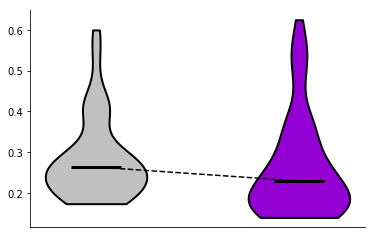

In [686]:

from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(us, s, alternative='greater')
print(U, p, len(us), len(s))

fig = plt.figure()
ax  = fig.gca()
vplot = plt.violinplot([us, s], showextrema=False, showmedians=True)
for color, bodies in zip(['silver','darkviolet'], vplot['bodies']):
        bodies.set_facecolor(color)
        bodies.set_edgecolor('k')
        bodies.set_alpha(1.0)
        bodies.set_linewidth(2.0)
vp = vplot['cmedians']
vp.set_edgecolor('k')
vp.set_linewidth(3)
plt.plot([1,2], [np.median(us), np.median(s)], color='k', linestyle='--')
plt.xticks([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()
plt.show()



3757.5 0.0001733785831433618 0.2288136 0.2650919
4718.5 0.22680783897850643 0.2631579 0.2650919


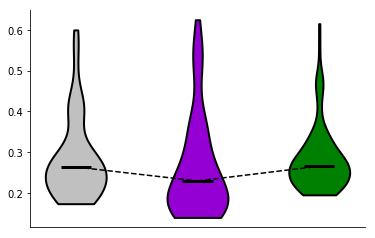

In [687]:

from scipy.stats import mannwhitneyu

U, p = mannwhitneyu(s, b3, alternative='less')
print(U, p, np.median(s), np.median(b3))
U, p = mannwhitneyu(us, b3, alternative='two-sided')
print(U, p, np.median(us), np.median(b3))

fig = plt.figure()
ax  = fig.gca()
vplot = plt.violinplot([us, s, b3], showextrema=False, showmedians=True)
for color, bodies in zip(['silver','darkviolet', 'green'], vplot['bodies']):
        bodies.set_facecolor(color)
        bodies.set_edgecolor('k')
        bodies.set_alpha(1.0)
        bodies.set_linewidth(2.0)
vp = vplot['cmedians']
vp.set_edgecolor('k')
vp.set_linewidth(3)
plt.plot([1,2], [np.median(us), np.median(s)], color='k', linestyle='--')
plt.plot([2,3], [np.median(s), np.median(b3)], color='k', linestyle='--')

plt.xticks([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()
plt.show()



In [434]:
ispos = np.where(reduced_adj>0)
isneg = np.where(reduced_adj<0)

pvals = reduced_adj[ispos].sum()
nvals = reduced_adj[isneg].sum()

print(pvals, nvals)

0.27947235 -421.1365
